# scgpgmm GMMGP
This actually works currently
https://pyro.ai/examples/scgpgmm.html
https://docs.scvi-tools.org/en/stable/user_guide/models/scgpgmm.html

In [1]:
# various import statements
import numpy as np

import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
from torch.optim import Adam
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.ops.indexing import Vindex
import pyro.contrib
import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
foo='hello'
bar='world'
import os
import sklearn
from sklearn import cluster
import pandas as pd
import re
import scanpy as sc
print(f"{foo=} {bar=}")
from torch import exp
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))
sc.settings.figdir=os.path.expanduser('~/WbFigures/AdultModelAnalysis/')
from decimal import Decimal

foo='hello' bar='world'


In [2]:
smoke_test=False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device="cpu"


cuda:0


In [3]:
def centered_sigmoid(x):
    return((torch.sigmoid(x)-0.5)*2)

def resampling_p_value(data, group_labels, num_iterations=1000):
    """
    Calculate the resampling p-value for the magnitude of input values, partitioned by two groups.
    
    Arguments:
    data -- A list or NumPy array of input values.
    group_labels -- A list or NumPy array of group labels corresponding to each value in the data.
    num_iterations -- The number of iterations to perform for the resampling (default: 1000).
    
    Returns:
    p_value -- The resampling p-value.
    """
    group_labels = np.array(group_labels)
    data = np.array(data)
    group1_data = data[group_labels == 1]
    group2_data = data[group_labels == 2]
    observed_difference = np.abs(np.mean(group1_data) - np.mean(group2_data))
    combined_data = np.concatenate((group1_data, group2_data))
    num_group1 = len(group1_data)
    num_group2 = len(group2_data)
    num_total = num_group1 + num_group2
    larger_difference_count = 0

    for _ in range(num_iterations):
        np.random.shuffle(combined_data)
        perm_group1 = combined_data[:num_group1]
        perm_group2 = combined_data[num_group1:]
        perm_difference = np.abs(np.mean(perm_group1) - np.mean(perm_group2))
        if perm_difference >= observed_difference:
            larger_difference_count += 1

    p_value = (larger_difference_count + 1) / (num_iterations + 1)
    return p_value

# Analysis

In [4]:
store_loc=os.path.expanduser('/mnt/sda/model_outs/')
#name_stem='RPCA_Adult_model_Sigmoid'
name_stem='RPCA_model_Sigmoid'
species_contrasts=dict(zip(['H/Q','H/R','H/M','R/M'],[[0,1],[0,2],[0,3],[2,3]]))
species_contrasts=dict(zip(['H/Q','H/M','Q/M'],[[0,1],[0,2],[1,2]]))

In [5]:
pyro.get_param_store().load(os.path.join(store_loc,name_stem+'.paramstore'))
#scgpgmm=torch.load(os.path.join(store_loc,name_stem+'.scgpgmm'))
adata=sc.read(os.path.join(store_loc,name_stem+'.h5ad'))

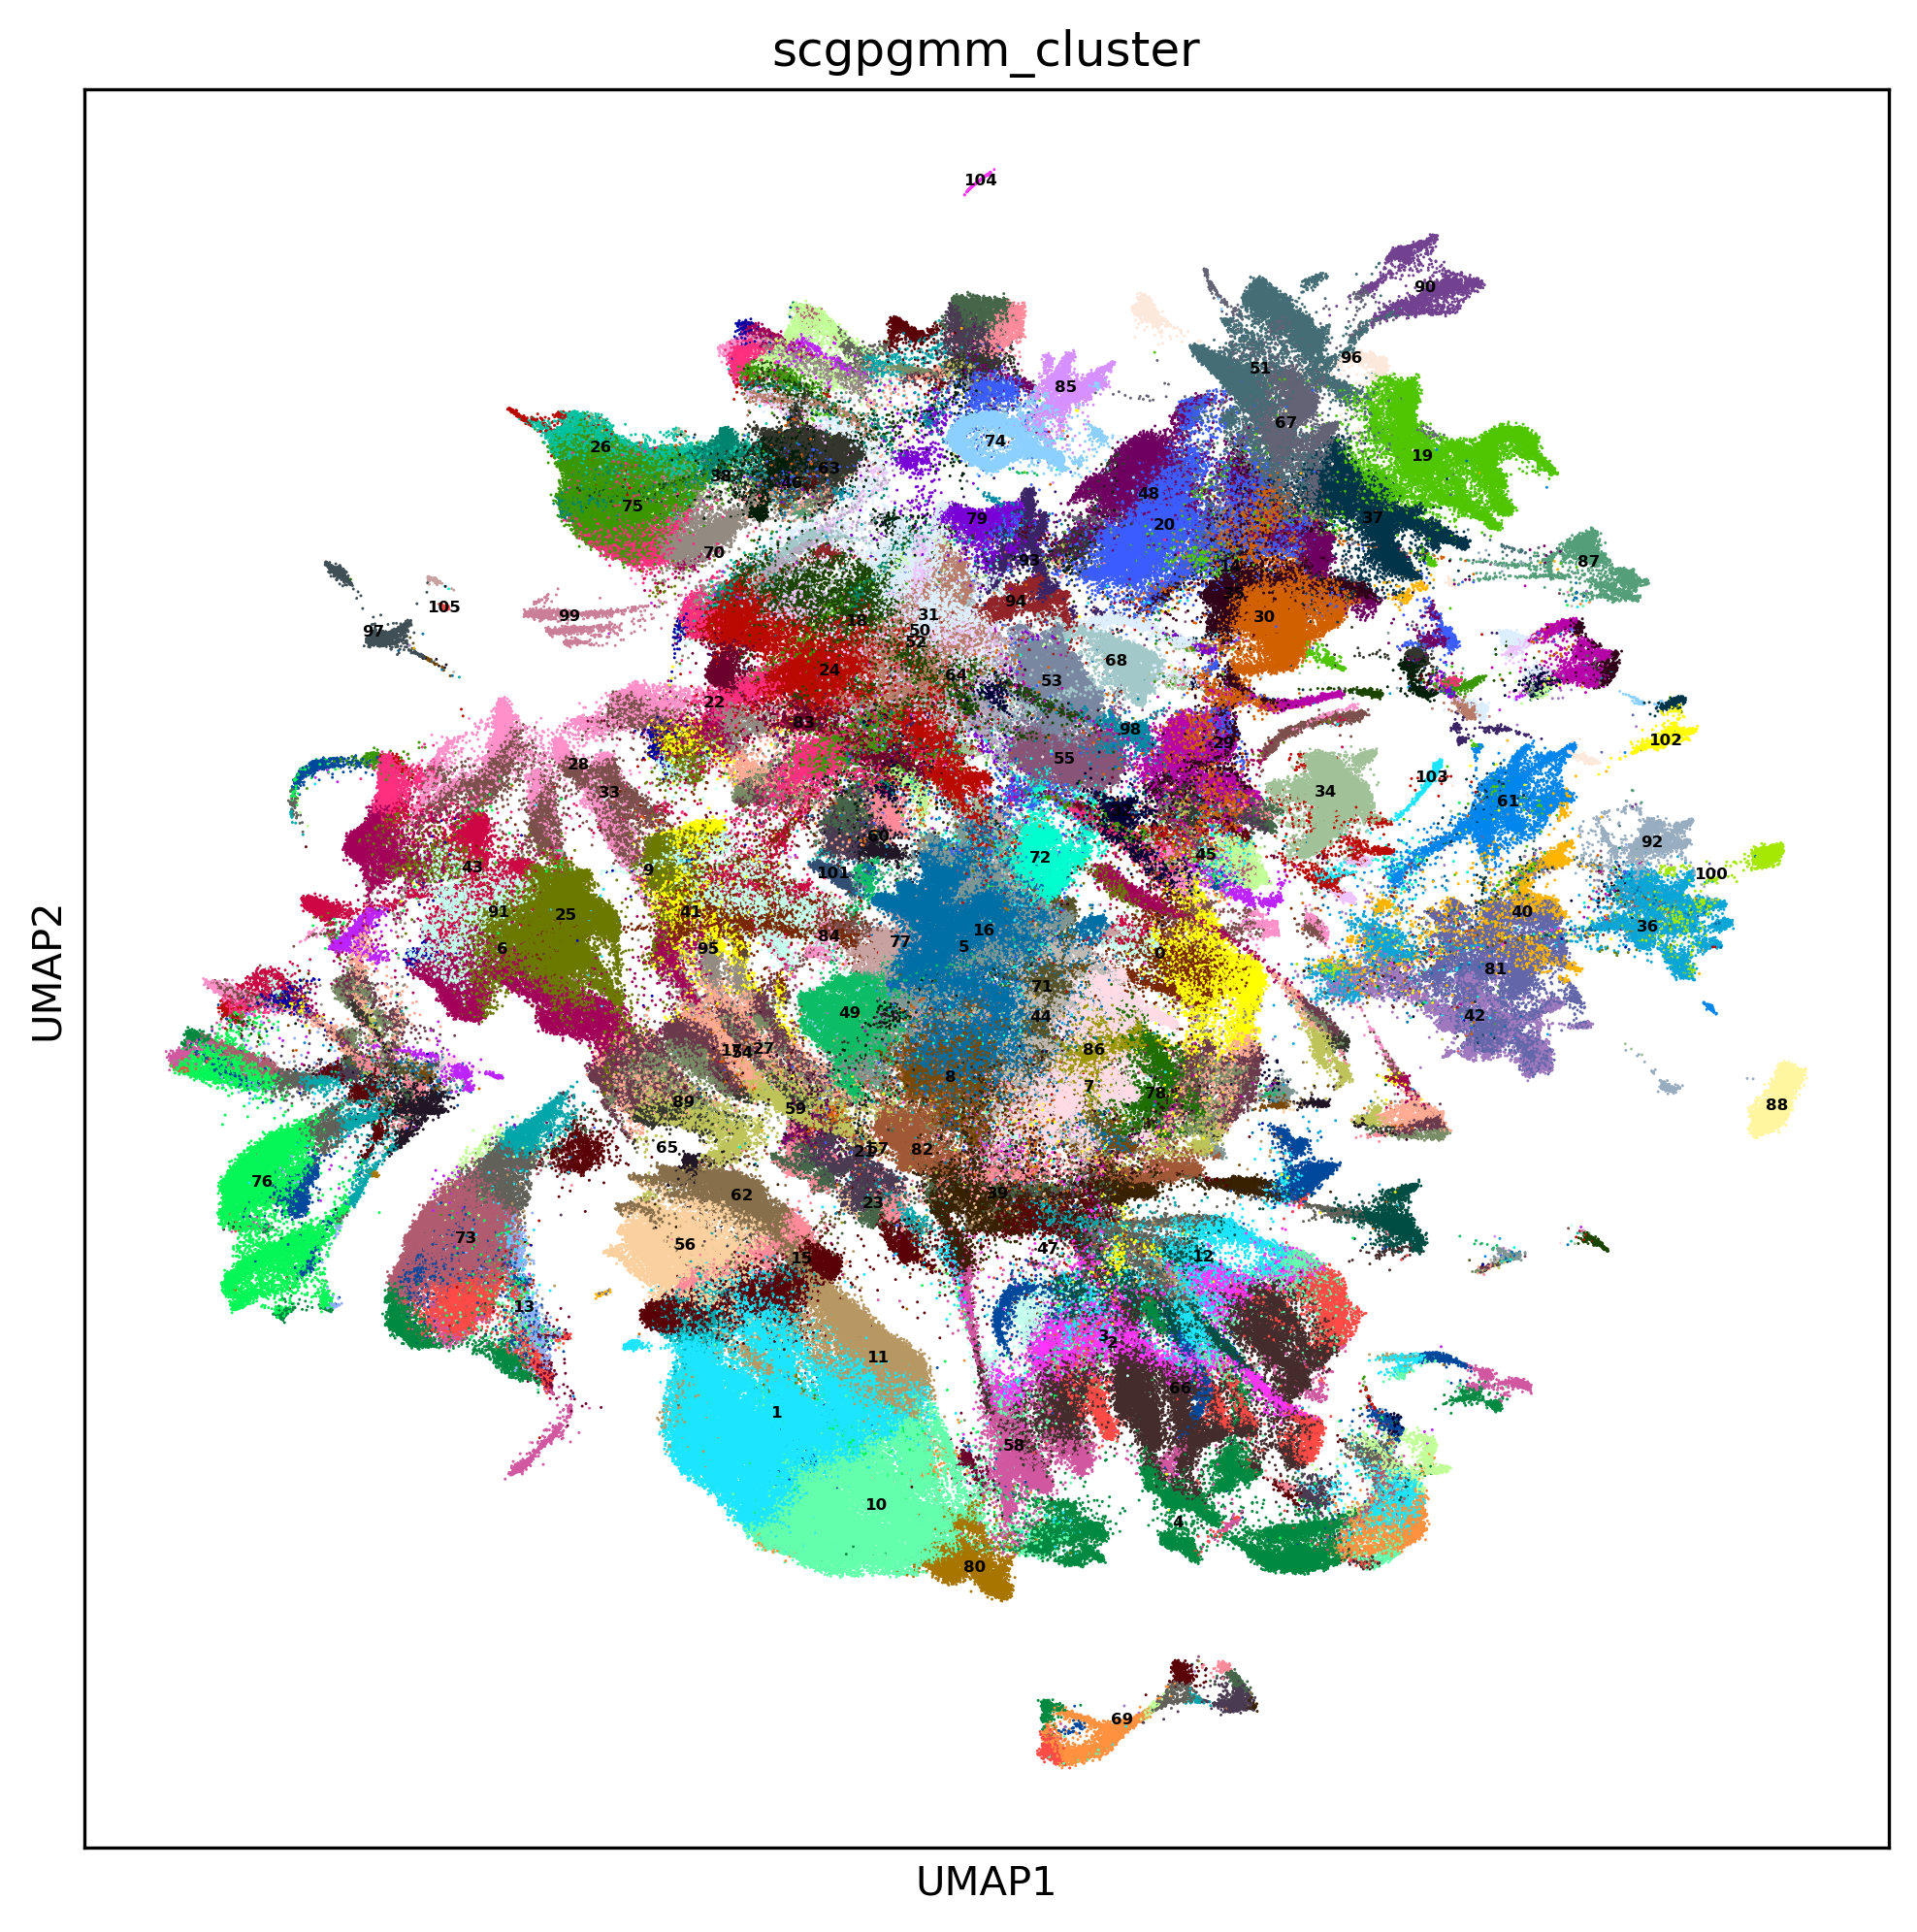

In [6]:
with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}):
    sc.pl.umap(adata,color='scgpgmm_cluster',legend_loc='on data',legend_fontsize=4,size=2,)

In [7]:
vcs=adata.obs['scgpgmm_cluster'].value_counts()>10
real_clusters=vcs[vcs].index.astype(int)

In [8]:
device='cpu'
cpu_dict=dict()
for i in pyro.get_param_store():
    cpu_dict[i]=pyro.get_param_store()[i].to(device).detach()

In [9]:
pd_psi_means=adata.obs.groupby('scgpgmm_cluster')['psi'].mean()
psi_means=np.zeros(cpu_dict['locs'].shape[0])
for i in pd_psi_means.index:
    psi_means[int(i)]=pd_psi_means[i]


In [10]:
#cpu_dict['locs']=centered_sigmoid(cpu_dict['locs'])

In [11]:
"""
cpu_dict['species_de']=cpu_dict['species_de'][:,real_clusters,:]
cpu_dict['species_dm']=cpu_dict['species_dm'][:,real_clusters,:]
cpu_dict['locs']=cpu_dict['locs'][real_clusters,:]
cpu_dict['scales']=cpu_dict['scales'][real_clusters,:]
cpu_dict['cluster_intercept']=cpu_dict['cluster_intercept'][real_clusters,:]
cpu_dict['locs_dynam']=cpu_dict['locs_dynam'][real_clusters,:]
psi_means=psi_means[real_clusters]
"""

"\ncpu_dict['species_de']=cpu_dict['species_de'][:,real_clusters,:]\ncpu_dict['species_dm']=cpu_dict['species_dm'][:,real_clusters,:]\ncpu_dict['locs']=cpu_dict['locs'][real_clusters,:]\ncpu_dict['scales']=cpu_dict['scales'][real_clusters,:]\ncpu_dict['cluster_intercept']=cpu_dict['cluster_intercept'][real_clusters,:]\ncpu_dict['locs_dynam']=cpu_dict['locs_dynam'][real_clusters,:]\npsi_means=psi_means[real_clusters]\n"

/home/mtschmitz/utils/miniconda3/envs/pyro/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


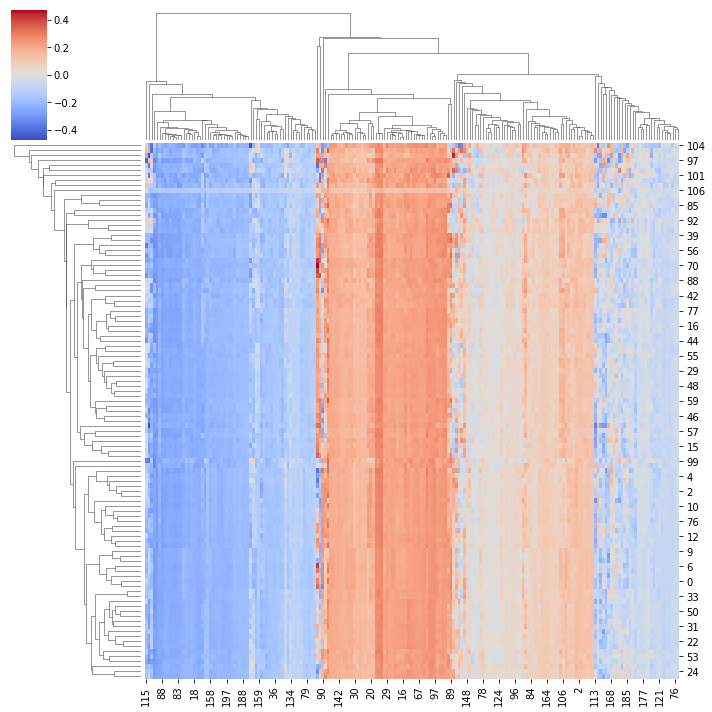

In [12]:
seaborn.clustermap(centered_sigmoid(cpu_dict['locs']),cmap='coolwarm')#,vmin=-1,vmax=1)

In [13]:
loc_dynams=0#(cpu_dict['locs_dynam'].T*torch.tensor(psi_means).to(device)).T.float()
cluster_means=((centered_sigmoid(cpu_dict['locs']+loc_dynams)@cpu_dict['z_decoder_weight'])+cpu_dict['cluster_intercept']).numpy()
#cluster_params=((pyro.param('anc_locs').detach().cpu().numpy()+loc_dynams)@pyro.param('z_decoder_weight').detach().cpu().numpy())
cluster_params=(np.sign(cluster_means)*0) + cluster_means
coefs=[]
for i in range(cluster_params.shape[0]):
    others=list(set(list(range(cluster_params.shape[0])))-set([i]))
    coefs.append((cluster_params[i:(i+1),:]-cluster_params[others,:].mean(0))/(cluster_params.std(0)))
coefs=np.concatenate(coefs,axis=0)



<AxesSubplot:ylabel='Count'>

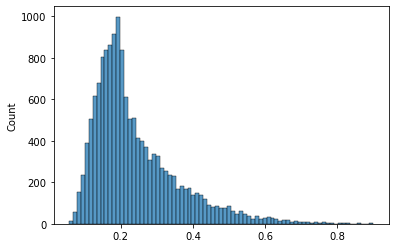

In [14]:
seaborn.histplot(cluster_params.std(0))

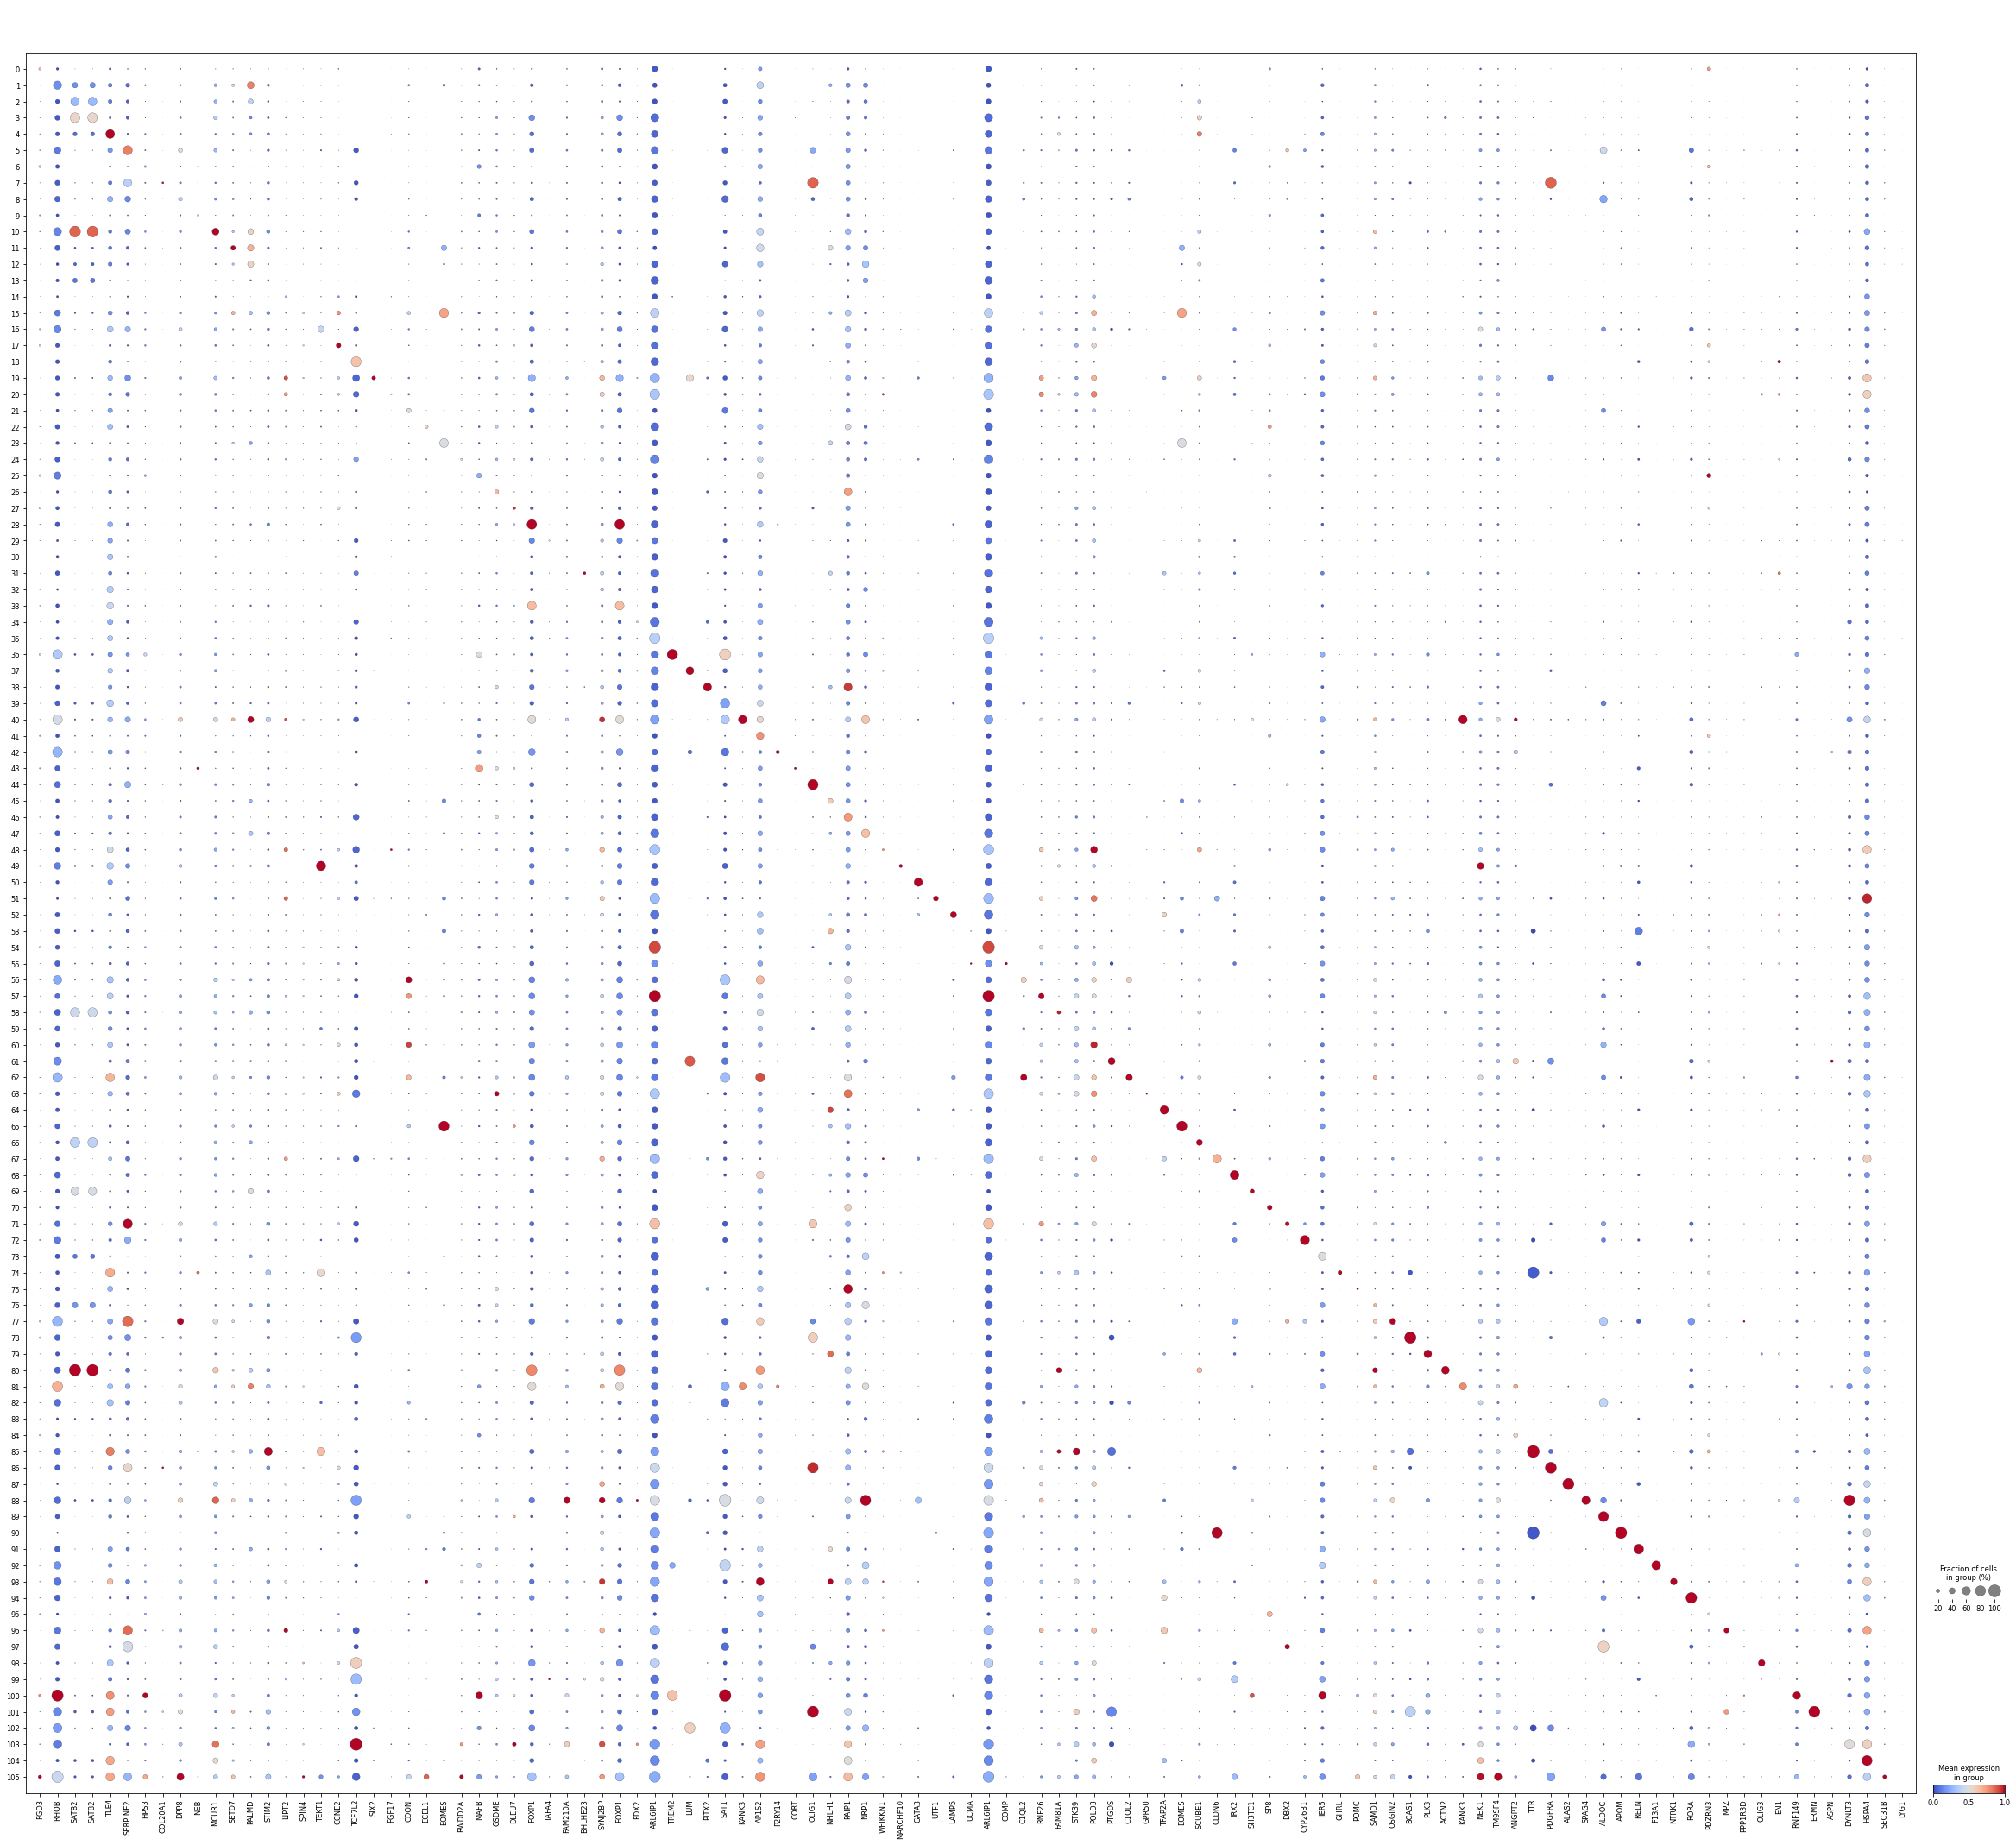

In [15]:
#sc.tl.dendrogram(adata,groupby='scgpgmm_cluster',use_rep='X_scgpgmm')
sc.pl.dotplot(adata,groupby='scgpgmm_cluster',var_names=pd.DataFrame(coefs.T,index=adata.var.index).idxmax(0),dendrogram=False,standard_scale='var',use_raw=False,cmap='coolwarm')

In [16]:
#original
#sc.pl.umap(adata,color=set(pd.DataFrame(coefs.T,index=adata.var.index).idxmax(0)),use_raw=False,cmap='Purples')

In [17]:
def gex_output(x,m,b):
    return((torch.softmax((x@m+b).detach(),-1)).log())

def gex_output(x,m,b):
    return((centered_sigmoid(x)@m+b).detach())

In [18]:
est_cluster_means=gex_output((cpu_dict['locs']+loc_dynams),(cpu_dict['z_decoder_weight']),cpu_dict['intercept']).numpy()

In [19]:
cluster_species=[]
for species_ind in list(range(cpu_dict['species_de'].shape[0])):
    cluster_species.append(gex_output(centered_sigmoid(cpu_dict['locs']+loc_dynams+cpu_dict['species_dm'][species_ind]),
                                      (cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][species_ind]),
                                      cpu_dict['species_de'][species_ind]))
estimated_ge=torch.stack(cluster_species)

In [20]:
cluster_species=[]
df=pd.DataFrame(adata.raw.X.todense()/adata.raw.X.sum(1))
df['scgpgmm_cluster']=list(adata.obs['scgpgmm_cluster'].astype(int))
df['species']=list(adata.obs['species'])
df['scgpgmm_cluster']=df['scgpgmm_cluster'].astype('category')
X=df.groupby(['species','scgpgmm_cluster']).mean()
for species_ind in adata.obs.species.cat.categories:
    cluster_species.append(X.loc[species_ind,:])
real_ge=np.stack(cluster_species)
real_ge=torch.tensor(real_ge)

In [21]:
"""
store_loc=os.path.expanduser('/mnt/sda/model_outs/')
name_stem='T8.0_LinearNoBN-HC0.2-BNapprox'

pyro.get_param_store().load(os.path.join(store_loc,name_stem+'.paramstore'))
scgpgmm=torch.load(os.path.join(store_loc,name_stem+'.scgpgmm'))
adata=sc.read(os.path.join(store_loc,name_stem+'.h5ad'))
"""

"\nstore_loc=os.path.expanduser('/mnt/sda/model_outs/')\nname_stem='T8.0_LinearNoBN-HC0.2-BNapprox'\n\npyro.get_param_store().load(os.path.join(store_loc,name_stem+'.paramstore'))\nscgpgmm=torch.load(os.path.join(store_loc,name_stem+'.scgpgmm'))\nadata=sc.read(os.path.join(store_loc,name_stem+'.h5ad'))\n"

In [22]:
cluster_species=[]
for species_ind in list(range(cpu_dict['species_de'].shape[0])):
    cluster_species.append(gex_output(centered_sigmoid(cpu_dict['locs']+loc_dynams),
                                      (cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][species_ind]),
                                      0))
cluster_species=torch.stack(cluster_species)
dc_diffs=cluster_species

In [23]:
cluster_species=[]
for species_ind in list(range(cpu_dict['species_de'].shape[0])):
    cluster_species.append(gex_output(centered_sigmoid(cpu_dict['locs']+loc_dynams),
                                      (cpu_dict['z_decoder_weight']),
                                      cpu_dict['species_de'][species_ind]))
de_diffs=torch.stack(cluster_species)


In [24]:
cluster_species=[]
for species_ind in list(range(cpu_dict['species_de'].shape[0])):
    cluster_species.append(gex_output(centered_sigmoid(cpu_dict['locs']+loc_dynams+cpu_dict['species_dm'][species_ind]),
                                      (cpu_dict['z_decoder_weight']),
                                      0))
dm_diffs=torch.stack(cluster_species)


In [25]:
HoM=estimated_ge[0]-estimated_ge[2]

In [26]:
#gene DE in different celltypes
(HoM@HoM.T)

tensor([[ 4.1678e+02,  7.5951e+01,  1.4039e+02,  ..., -8.3826e+00,
          1.2588e-01,  1.0047e+00],
        [ 7.5951e+01,  4.6748e+02,  2.8088e+02,  ...,  2.5015e+00,
         -6.1813e-01,  2.6263e-01],
        [ 1.4039e+02,  2.8088e+02,  4.4427e+02,  ...,  1.2816e+00,
         -3.4938e-01,  7.6934e-01],
        ...,
        [-8.3826e+00,  2.5015e+00,  1.2816e+00,  ...,  2.5309e+00,
          5.3638e-01, -2.6540e-02],
        [ 1.2588e-01, -6.1813e-01, -3.4938e-01,  ...,  5.3638e-01,
          6.5889e-01,  1.2014e-01],
        [ 1.0047e+00,  2.6263e-01,  7.6934e-01,  ..., -2.6540e-02,
          1.2014e-01,  2.3530e-01]])

In [27]:
class_color_dict

NameError: name 'class_color_dict' is not defined

In [ ]:
leiden_classnames=adata.obs.groupby('leiden_class')['leiden'].value_counts().unstack().idxmax().to_dict()
class_color_dict=dict(zip(adata.obs['leiden_class'].cat.categories,adata.uns['leiden_class_colors']))
class_colors=[class_color_dict[leiden_classnames[str(i)]] for i in range (HoM.shape[0])]

In [ ]:
leiden_region=adata.obs.groupby('region')['leiden'].value_counts().unstack().idxmax().to_dict()
region_color_dict=dict(zip(adata.obs['region'].cat.categories,adata.uns['region_colors']))
region_colors=[region_color_dict[leiden_region[str(i)]] for i in range (HoM.shape[0])]

In [ ]:
seaborn.clustermap((HoM>0.5).float()@(HoM.T>0.5).float(),row_colors=[region_colors,class_colors],col_colors=[region_colors,class_colors],col_linkage=adata.uns['dendrogram_leiden']['linkage'],metric='cityblock',method='average')
plt.title('# Divergent Genes Shared Across Clusters')

In [ ]:
de_sub=de_diffs[0]-de_diffs[2]
seaborn.clustermap((de_sub.abs()>0.01).float()@(de_sub.abs().T>0.01).float())
plt.title('# Divergent Genes Shared Across Clusters')


In [ ]:
dc_sub=dc_diffs[0]-dc_diffs[2]
seaborn.clustermap((dc_sub>0.1).float()@(dc_sub.T>0.1).float())
plt.title('# DC Genes Shared Across Clusters')

In [ ]:
dm_sub=dm_diffs[0]-dm_diffs[2]
seaborn.clustermap((dm_sub>0.1).float()@(dm_sub.T>0.1).float())
plt.title('# DM Genes Shared Across Clusters')

In [ ]:
def torch_corr2_coeff(A, B):
    #Take obs as rows
    A=A.T
    B=B.T
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]
    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)
    # Finally get corr coeff
    return  torch.matmul(A_mA, B_mB.T) / (torch.matmul(ssA[:, None],ssB[None]))**0.5

def corr2_coeff(A, B):
    #Take obs as rows
    A=A.T
    B=B.T
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]
    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)
    # Finally get corr coeff
    return  np.dot(A_mA, B_mB.T) / (np.dot(ssA[:, None],ssB[None]))**0.5

In [ ]:
seaborn.clustermap((HoM>0.5).float()@(HoM.T>0.5).float())
plt.title('# DE Genes Shared Across Clusters')

In [ ]:
seaborn.heatmap(corr2_coeff((dm_diffs[0]-dm_diffs[1]).numpy().T,(dc_diffs[0]-dc_diffs[1]).numpy().T))
plt.show()
seaborn.heatmap(corr2_coeff((de_diffs[0]-de_diffs[1]).numpy().T,(dc_diffs[0]-dc_diffs[1]).numpy().T))
plt.show()
seaborn.heatmap(corr2_coeff((de_diffs[0]-de_diffs[1]).numpy().T,(dm_diffs[0]-dm_diffs[1]).numpy().T))
plt.show()

In [ ]:
seaborn.heatmap(corr2_coeff(cpu_dict['z_decoder_weight'].numpy().T,cpu_dict['species_dc'][0].numpy().T))

In [ ]:
seaborn.heatmap(corr2_coeff((estimated_ge[1]).exp().numpy().T,(real_ge[1]).numpy().T))

In [ ]:
seaborn.histplot((real_ge+1e-10).log().numpy().flatten())

In [ ]:
seaborn.histplot(estimated_ge.numpy().flatten())

In [ ]:
gex_output((cpu_dict['locs']+loc_dynams),
                                      (cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][0][i]),
                                      0)

In [ ]:
gex_output((cpu_dict['locs']+loc_dynams),
                                      (cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][1][i]),
                                      0)

In [ ]:
(cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][0][i])


In [ ]:
def gex_output(x,m,b):
    #print('x',x)
    #print('m',m)
    #print('x@m',x@m)
    return((x@m+b).detach())

In [ ]:
cpu_dict['species_dc'][0].shape

In [ ]:
def make_col_mask(shape,ind):
    mask=torch.zeros(shape)
    mask[:,ind]=1.
    return(mask)

def make_row_mask(shape,ind):
    mask=torch.zeros(shape)
    mask[ind,...]=1.
    return(mask)

In [ ]:
cluster_species=[]
for i in range(cpu_dict['species_dc'].shape[1]):
    mask=make_row_mask(cpu_dict['species_dc'][0].shape,i)
    cluster_species.append(gex_output((cpu_dict['locs']+loc_dynams),
                                      (torch.zeros(cpu_dict['z_decoder_weight'].shape)+cpu_dict['species_dc'][0]*mask),
                                      0)-gex_output((cpu_dict['locs']+loc_dynams),
                                      (torch.zeros(cpu_dict['z_decoder_weight'].shape)+cpu_dict['species_dc'][1]*mask),
                                      0))

    """
cluster_species=[]   
for i in range(cpu_dict['species_dc'].shape[1]):
    cluster_species.append(gex_output((cpu_dict['locs']+loc_dynams),
                                      (torch.ones(cpu_dict['z_decoder_weight'].shape)+cpu_dict['species_dc'][0][i]),
                                      0)-gex_output((cpu_dict['locs']+loc_dynams),
                                      (torch.ones(cpu_dict['z_decoder_weight'].shape)+torch.randn(cpu_dict['species_dc'][1][i].shape)),
                                      0))
"""      

cluster_species=torch.stack(cluster_species)
component_diffs=cluster_species

In [ ]:
seaborn.heatmap(torch.einsum('...bi,...ij->...bj',(cpu_dict['locs']+loc_dynams),cpu_dict['species_dc'][0]))

In [ ]:
seaborn.heatmap((cpu_dict['locs']+loc_dynams)@cpu_dict['z_decoder_weight'])

In [ ]:
seaborn.heatmap(cpu_dict['locs']+loc_dynams)

In [ ]:
seaborn.heatmap(corr2_coeff((cpu_dict['locs']+loc_dynams).T,(cpu_dict['locs']+loc_dynams).T))


In [ ]:
seaborn.heatmap(corr2_coeff(dc_diffs[0].T,dc_diffs[1].T))

In [ ]:
component_diffs[i,:,:].T

In [ ]:
seaborn.heatmap(component_diffs[0,:,:]@component_diffs[0,:,:].T)

In [ ]:
corr2_coeff(component_diffs[i,:,:].T,component_diffs[i,:,:].T)

In [ ]:
for i in range(10):
    seaborn.heatmap(cpu_dict['locs'][:,i:i+1])
    plt.show()
    seaborn.heatmap(component_diffs[i,:,:])
    plt.show()
    seaborn.heatmap(corr2_coeff(component_diffs[i,:,:].T,component_diffs[i,:,:].T))
    plt.show()

In [ ]:
seaborn.heatmap(corr2_coeff(cpu_dict['species_dc'][0].T,cpu_dict['species_dc'][1].T))

In [ ]:
seaborn.heatmap(cpu_dict['locs']+loc_dynams+cpu_dict['species_dm'][species_ind])

In [ ]:
gex_output((cpu_dict['locs']+loc_dynams+cpu_dict['species_dm'][species_ind]),
                                      (cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][species_ind]),
                                      cpu_dict['species_de'][species_ind])

In [ ]:
seaborn.heatmap((cpu_dict['locs']+loc_dynams+cpu_dict['species_dm'][0])@(cpu_dict['z_decoder_weight']+cpu_dict['species_dc'][0])+cpu_dict['species_de'][0])

In [ ]:
seaborn.heatmap(component_diffs[1,:,:])
plt.show()

In [ ]:
seaborn.heatmap(np.log(component_diffs.abs().sum(2)+1))
plt.show()
seaborn.heatmap(cpu_dict['locs'].T,cmap='coolwarm')


In [ ]:
seaborn.heatmap(dc_diffs[1])

In [ ]:
seaborn.heatmap(dc_diffs[2])

In [ ]:
cpu_dict['species_dc']

In [ ]:
seaborn.heatmap(cpu_dict['species_dc'][0],cmap='coolwarm')
plt.show()
seaborn.heatmap(cpu_dict['species_dc'][1],cmap='coolwarm')

In [ ]:
params=dc_diffs
comparison=(params[0]-params[1])
seaborn.heatmap(comparison.numpy(),cmap='coolwarm')
plt.show()
seaborn.heatmap(corr2_coeff(comparison.numpy().T,comparison.numpy().T),cmap='coolwarm')



In [ ]:
seaborn.histplot(comparison.numpy().flatten())

In [ ]:
params_dict=dict(zip(['DM','DC','DI','estimated GE','real GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge.exp(),real_ge]))
fig, ax = plt.subplots(nrows=len(species_contrasts), ncols=len(params_dict),figsize=(30,30))
for i,listname in enumerate(species_contrasts.keys()):
    species=species_contrasts[listname]
    for j,paramname in enumerate(params_dict.keys()):
        params=params_dict[paramname]
        comparison=(params[species[0]]-params[species[1]])
        seaborn.heatmap(comparison.numpy(),ax=ax[i][j],cmap='coolwarm',vmin=-1, vmax=1)
        ax[i][j].set_title(listname+' '+paramname+' Gex',y=1.)

plt.savefig(os.path.join(sc.settings.figdir,'CrossParameterMultipliedOutGexHeatmaps.pdf'),format = "pdf")

In [ ]:
params_dict=dict(zip(['DM','DC','DI','estimated GE','real GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge.exp(),real_ge]))
fig, ax = plt.subplots(nrows=len(species_contrasts), ncols=len(params_dict),figsize=(30,30))
for i,listname in enumerate(species_contrasts.keys()):
    species=species_contrasts[listname]
    for j,paramname in enumerate(params_dict.keys()):
        params=params_dict[paramname]
        comparison=(params[species[0]]-params[species[1]])
        seaborn.heatmap(corr2_coeff(comparison.numpy().T,comparison.numpy().T),ax=ax[i][j],cmap='coolwarm',vmin=-1, vmax=1)
        ax[i][j].set_title(listname+' '+paramname+' Corr',y=1.)

plt.savefig(os.path.join(sc.settings.figdir,'CrossParameterMultipliedOutCorrHeatmaps.pdf'),format = "pdf")

In [ ]:
params_dict=dict(zip(['DM','DC','DI','estimated GE','real GE'],[cpu_dict['species_dm'],cpu_dict['species_dc'],cpu_dict['species_de']]))
fig, ax = plt.subplots(nrows=len(species_contrasts), ncols=len(params_dict),figsize=(30,30))
for i,(species_ind,species) in enumerate(zip(adata.obs.species.cat.codes,adata.obs.species.cat.categories)):
    for j,paramname in enumerate(params_dict.keys()):
        params=params_dict[paramname]
        comparison=params[species_ind]
        seaborn.heatmap(corr2_coeff(comparison.numpy().T,comparison.numpy().T),ax=ax[i][j],cmap='coolwarm',vmin=-1, vmax=1)
        ax[i][j].set_title(species+' '+paramname+' Corr',y=1.)
plt.savefig(os.path.join(sc.settings.figdir,'CrossParameterCorrHeatmaps.pdf'),format = "pdf")

In [ ]:
seaborn.clustermap(np.corrcoef(cpu_dict['species_dc'][0].numpy()))

In [ ]:
tf_list=pd.read_csv('/home/mtschmitz/utils/TF_lambert_PMID_29425488/DatabaseExtract_v_1.01.txt',sep='\t')
tf_list['HGNC symbol']

TFs=np.where(adata.var.index.isin(tf_list['HGNC symbol']))[0]
notTFs=np.where(~adata.var.index.isin(tf_list['HGNC symbol']))[0]

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
seaborn.set_theme(style="ticks", rc=custom_params)

In [ ]:
qHtQ_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qHtQ_syntenic.tsv',sep='\t')
qQtH_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qQtH_syntenic.tsv',sep='\t')
qHtM_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qHtM_syntenic.tsv',sep='\t')
qMtH_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qMtH_syntenic.tsv',sep='\t')
qQtM_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qQtM_syntenic.tsv',sep='\t')
qMtQ_syntenic=pd.read_csv('/mnt/sda/toga_annotations/synteny_intersect_outs/qMtQ_syntenic.tsv',sep='\t')

In [ ]:
HQgenes=qHtQ_syntenic['17'].unique()
QHgenes=qQtH_syntenic['3'].str.replace('^ENST[0-9]+\.','').str.replace('\.[0-9]*$','').unique()

In [ ]:
def resampling_p_value(data, group_labels,fun, num_iterations=1000):
    """
    Calculate the resampling p-value for the magnitude of input values, partitioned by two groups.
    
    Arguments:
    data -- A list or NumPy array of input values.
    group_labels -- A list or NumPy array of group labels corresponding to each value in the data.
    num_iterations -- The number of iterations to perform for the resampling (default: 1000).
    
    Returns:
    p_value -- The resampling p-value.
    """
    group_labels = np.array(group_labels)
    data = np.array(data)
    group1_data = data[group_labels]
    group2_data = data[~group_labels]
    observed_difference = np.abs(np.mean(fun(group1_data)) - np.mean(fun(group2_data)))

    combined_data = np.concatenate((group1_data, group2_data))
    num_group1 = len(group1_data)
    num_group2 = len(group2_data)
    num_total = num_group1 + num_group2
    larger_difference_count = 0

    for _ in tqdm.tqdm(range(num_iterations)):
        np.random.shuffle(combined_data)
        perm_group1 = combined_data[:num_group1]
        perm_group2 = combined_data[num_group1:]
        perm_difference = np.abs(np.mean(fun(perm_group1)) - np.mean(fun(perm_group2)))
        if perm_difference >= observed_difference:
            larger_difference_count += 1

    p_value = (larger_difference_count + 1) / (num_iterations + 1)
    return p_value

def resampling_slope_p_value(x, y, num_iterations=1000):
    """
    Calculate the resampling p-value for the slope of the linear fit of two variables.
    
    Arguments:
    x -- A 1D NumPy array or list representing the independent variable.
    y -- A 1D NumPy array or list representing the dependent variable.
    num_iterations -- The number of iterations to perform for the resampling (default: 1000).
    
    Returns:
    p_value -- The resampling p-value.
    """
    x = np.array(x)
    y = np.array(y)
    observed_slope = np.polyfit(x, y, 1)[0]
    num_data = len(x)
    larger_slope_count = 0

    for _ in tqdm.tqdm(range(num_iterations)):
        indices = np.random.choice(num_data, num_data, replace=True)
        resampled_x = x
        resampled_y = y[indices]
        resampled_slope = np.polyfit(resampled_x, resampled_y, 1)[0]
        if np.abs(resampled_slope) >= np.abs(observed_slope):
            larger_slope_count += 1

    p_value = (larger_slope_count + 1) / (num_iterations + 1)
    return p_value

num_iterations=5000

In [ ]:
def flatten_var(x):
    return(np.var(x.flatten()))
    
genelists=dict(zip(['humansyntenic','macaquesyntenic','TFs'],[HQgenes,QHgenes,tf_list['HGNC symbol']]))
params_dict=dict(zip(['DM','DC','DI'],[dm_diffs,dc_diffs,de_diffs]))
fig, ax = plt.subplots(nrows=len(genelists), ncols=len(params_dict),figsize=(20,20))
abs_magnitudes=np.abs(dm_diffs[0]-dm_diffs[1])+np.abs(de_diffs[0]-de_diffs[1])+np.abs(dc_diffs[0]-dc_diffs[1])
for i,listname in enumerate(genelists.keys()):
    genes=genelists[listname]
    for j,paramname in enumerate(params_dict.keys()):
        params=params_dict[paramname]
        gidx=np.where(adata.var.index.isin(genes))[0]
        ngidx=np.where(~adata.var.index.isin(genes))[0]
        comparison=(params[0]-params[1])
        
        seaborn.histplot(np.clip((comparison).numpy()[:,gidx].flatten(),-10,10),bins=100,stat='percent',color='r',ax=ax[i][j])
        seaborn.histplot(np.clip((comparison).numpy()[:,ngidx].flatten(),-10,10),bins=100,stat='percent',ax=ax[i][j])
        pval=resampling_p_value((comparison).numpy().T, adata.var.index.isin(genes),flatten_var, num_iterations=num_iterations)
        ax[i][j].set_title(paramname+" "+listname+'\n'+
                          'in list var ='+'%.2E'%Decimal(str(np.var(comparison[:,gidx].numpy().flatten())))+'\n'+
                           'out list var ='+'%.2E'%Decimal(str(np.var(comparison[:,ngidx].numpy().flatten())))+'\n'+
                           'resampled pval='+'%.2E'%Decimal(str(pval)),
                           y=0.9
                          )
        #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)
red_patch = matplotlib.patches.Patch(color='red', label='Within List')
blue_patch = matplotlib.patches.Patch(color='blue', label='Not Within List')
fig.legend(handles=[red_patch,blue_patch],loc='center right')
fig.suptitle('H/M Fold Change',y=0.92,fontsize=18)
plt.show(fig)

In [ ]:
def flatten_median(x):
    return(np.median(x.flatten()))

genelists=dict(zip(['humansyntenic','macaquesyntenic','TFs'],[HQgenes,QHgenes,tf_list['HGNC symbol']]))
params_dict=dict(zip(['DM','DC','DI'],[dm_diffs,dc_diffs,de_diffs]))
fig, ax = plt.subplots(nrows=len(genelists), ncols=len(params_dict),figsize=(20,20))
abs_magnitudes=np.abs(dm_diffs[0]-dm_diffs[1])+np.abs(de_diffs[0]-de_diffs[1])+np.abs(dc_diffs[0]-dc_diffs[1])
for i,listname in enumerate(genelists.keys()):
    genes=genelists[listname]
    for j,paramname in enumerate(params_dict.keys()):
        params=params_dict[paramname]
        gidx=np.where(adata.var.index.isin(genes))[0]
        ngidx=np.where(~adata.var.index.isin(genes))[0]
        comparison=(params[0]-params[1]).abs()/(abs_magnitudes)
        seaborn.histplot(np.clip((comparison).numpy()[:,gidx].flatten(),-1,1),bins=100,stat='percent',color='r',ax=ax[i][j])
        seaborn.histplot(np.clip((comparison).numpy()[:,ngidx].flatten(),-1,1),bins=100,stat='percent',ax=ax[i][j])
        pval=resampling_p_value((comparison).numpy().T, adata.var.index.isin(genes),flatten_median, num_iterations=num_iterations)
        ax[i][j].set_title(paramname+" "+listname+'\n'+
                          'in list median ='+'%.2E'%Decimal(str(np.median(comparison[:,gidx])))+'\n'+
                          'out list median ='+'%.2E'%Decimal(str(np.median(comparison[:,ngidx])))+'\n'+
                          'resampled pval='+'%.2E'%Decimal(str(pval)),
                           y=0.80
                          )
        #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)

red_patch = matplotlib.patches.Patch(color='red', label='Within List')
blue_patch = matplotlib.patches.Patch(color='blue', label='Not Within List')
fig.legend(handles=[red_patch,blue_patch],loc='center right')
fig.suptitle('Percent of total H/M LFC magnitude',y=0.9,fontsize=18)
plt.show(fig)

In [ ]:
q_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_Q.tsv',sep='\t')
h_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_H.tsv',sep='\t')
m_length_intergenic=pd.read_csv('/mnt/sda/toga_annotations/GeneSizeAndIntergenic_M.tsv',sep='\t')

In [ ]:
seaborn.histplot(np.log10(h_length_intergenic['left']+m_length_intergenic['right']+1))

In [ ]:

#Intergenic Distance
intergenic_dfs=dict(zip(['human','macaque','mouse'],[h_length_intergenic,q_length_intergenic,m_length_intergenic]))
species_dict=dict(zip(adata.obs.species.cat.categories,list(range(cpu_dict['species_de'].shape[0]))))
params_dict=dict(zip(['DM','DC','DI','estimated GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge]))#,'real GE',real_ge

for contrast in species_contrasts.keys():
    fig, ax = plt.subplots(nrows=len(species_dict), ncols=len(params_dict),figsize=(30,30))
    for i,species in enumerate(species_dict.keys()):
        species_ind=species_dict[species]
        for j,paramname in enumerate(params_dict.keys()):
            if species not in intergenic_dfs.keys():
                continue
            params=params_dict[paramname]
            idf=intergenic_dfs[species]
            idf=idf.loc[(idf.loc[:,'left']+idf.loc[:,'right'])>0,:]
            param_contrast=params[species_contrasts[contrast][0]]-params[species_contrasts[contrast][1]]
            adata_genes=adata.var.index.isin(idf['gene'])
            genes=adata.var.index[adata_genes]
            idf.index=idf['gene']
            idf=idf.loc[genes,:]
            x=np.log10(idf.loc[:,'left']+idf.loc[:,'right']+1)
            #x=np.log10(idf.loc[:,['left','right']].min(1)+1)
            y=param_contrast[:,adata_genes].var(0)
            pval=resampling_slope_p_value(x.to_numpy(),y.numpy(), num_iterations=num_iterations)

            #y=np.abs(param_contrast[:,adata_genes]).max(0)[0]
            seaborn.scatterplot(x,y,color='black',ax=ax[i][j],alpha=0.1,legend=None)        
            a, b = np.polyfit(x, y, 1)
            model=np.poly1d([a,b])
            ax[i][j].plot(x, a*x+b)
            ax[i][j].set_xlim((0,x.max()))
            ax[i][j].set_ylim((0,y.max()))
            r2=sklearn.metrics.r2_score(y,model(x))
            #seaborn.regplot((idf.loc[:,'left']+idf.loc[:,'right']+1),param_contrast[:,adata_genes].var(0).flatten(),color='black',ax=ax[i][j])        
            ax[i][j].set_title(paramname+" Distances in "+species+'\n'+
                               'm='+'%.2E'%Decimal(a)+', b='+'%.2E'%Decimal(b)+', r^2='+'%.2E'%Decimal(r2)+'\n'+
                                'resampled pval='+'%.2E'%Decimal(str(pval)),
                               y=1
                              )
            #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)
    fig.suptitle('Log10 Intergenic Distance (x) vs '+contrast+' Var Parameter (y)',y=0.93,fontsize=18)
    plt.show(fig)

In [ ]:
#Distance To Closest gene 
intergenic_dfs=dict(zip(['human','macaque','mouse'],[h_length_intergenic,q_length_intergenic,m_length_intergenic]))
species_dict=dict(zip(adata.obs.species.cat.categories,list(range(cpu_dict['species_de'].shape[0]))))
params_dict=dict(zip(['DM','DC','DI','estimated GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge]))#,'real GE',real_ge

for contrast in species_contrasts.keys():
    fig, ax = plt.subplots(nrows=len(species_dict), ncols=len(params_dict),figsize=(30,30))
    for i,species in enumerate(species_dict.keys()):
        species_ind=species_dict[species]
        for j,paramname in enumerate(params_dict.keys()):
            if species not in intergenic_dfs.keys():
                continue
            params=params_dict[paramname]
            idf=intergenic_dfs[species]
            idf=idf.loc[(idf.loc[:,'left']+idf.loc[:,'right'])>0,:]
            idf=idf.loc[idf.loc[:,['left','right']].min(1)>0,:]

            param_contrast=params[species_contrasts[contrast][0]]-params[species_contrasts[contrast][1]]
            adata_genes=adata.var.index.isin(idf['gene'])
            genes=adata.var.index[adata_genes]
            idf.index=idf['gene']
            idf=idf.loc[genes,:]
            #x=idf.loc[:,'left'],idf.loc[:,'right']
            x=np.log10(idf.loc[:,['left','right']].min(1)+1)
            y=param_contrast[:,adata_genes].var(0)
            #y=np.abs(param_contrast[:,adata_genes]).max(0)[0]
            seaborn.scatterplot(x,y,color='black',ax=ax[i][j],alpha=0.1)        
            a, b = np.polyfit(x, y, 1)
            model=np.poly1d([a,b])
            ax[i][j].plot(x, a*x+b)
            r2=sklearn.metrics.r2_score(y,model(x))
            ax[i][j].set_xlim((0,x.max()))
            ax[i][j].set_ylim((0,y.max()))
            pval=resampling_slope_p_value(x.to_numpy(),y.numpy(), num_iterations=num_iterations)
                                            
            #seaborn.regplot((idf.loc[:,'left']+idf.loc[:,'right']+1),param_contrast[:,adata_genes].var(0).flatten(),color='black',ax=ax[i][j])        
            ax[i][j].set_title(paramname+" "+species+'\n'+
                               'm='+'%.2E'%Decimal(str(a))+', b='+'%.2E'%Decimal(str(b))+', r^2='+'%.2E'%Decimal(str(r2))+
                               '\n'+'resampled pval='+'%.2E'%Decimal(str(pval)),
                               y=1
                              )
            #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)
    fig.suptitle('Log10 Nearest Gene in Species (x) vs '+contrast+' Var Parameter (y)',y=0.93,fontsize=18)
    plt.show(fig)

In [ ]:
#Gene Size
intergenic_dfs=dict(zip(['human','macaque','mouse'],[h_length_intergenic,q_length_intergenic,m_length_intergenic]))
species_dict=dict(zip(adata.obs.species.cat.categories,list(range(cpu_dict['species_de'].shape[0]))))
params_dict=dict(zip(['DM','DC','DI','estimated GE'],[dm_diffs,dc_diffs,de_diffs,estimated_ge]))#,'real GE',real_ge

for contrast in species_contrasts.keys():
    fig, ax = plt.subplots(nrows=len(species_dict), ncols=len(params_dict),figsize=(30,30))
    for i,species in enumerate(species_dict.keys()):
        species_ind=species_dict[species]
        for j,paramname in enumerate(params_dict.keys()):
            if species not in intergenic_dfs.keys():
                continue
            params=params_dict[paramname]
            idf=intergenic_dfs[species]
            idf=idf.loc[idf['size']<1e7,:]
            param_contrast=params[species_contrasts[contrast][0]]-params[species_contrasts[contrast][1]]
            adata_genes=adata.var.index.isin(idf['gene'])
            genes=adata.var.index[adata_genes]
            idf.index=idf['gene']
            idf=idf.loc[genes,:]
            #x=idf.loc[:,'left'],idf.loc[:,'right']
            x=np.log10(idf.loc[:,['size']].min(1))
            y=param_contrast[:,adata_genes].var(0)#.abs().sum(0)#.var(0)
            #y=np.abs(param_contrast[:,adata_genes]).max(0)[0]
            seaborn.scatterplot(x,y,color='black',ax=ax[i][j],alpha=0.1)        
            a, b = np.polyfit(x, y, 1)
            model=np.poly1d([a,b])
            pval=resampling_slope_p_value(x.to_numpy(),y.numpy(), num_iterations=num_iterations)#np.random.choice(y.numpy(),len(y.numpy()))
            ax[i][j].plot(x, a*x+b)
            r2=sklearn.metrics.r2_score(y,model(x))
            ax[i][j].set_xlim((0,x.max()))
            ax[i][j].set_ylim((0,y.max()))
            #seaborn.regplot((idf.loc[:,'left']+idf.loc[:,'right']+1),param_contrast[:,adata_genes].var(0).flatten(),color='black',ax=ax[i][j])        
            ax[i][j].set_title(paramname+" "+species+'\n'+
                               'm='+'%.2E'%Decimal(str(a))+', b='+'%.2E'%Decimal(str(b))+', r^2='+'%.2E'%Decimal(str(r2))+
                               '\n'+'resampled pval='+'%.2E'%Decimal(str(pval)),
                               y=1
                              )
            #ax[i][j].set_title('in median ='+str(np.median(comparison[:,gidx]))+'\nout median ='+str(np.median(comparison[:,ngidx])),y=0.8, fontsize=10)
    fig.suptitle('Log10 Species Gene Length (x) vs '+contrast+' Var Parameter (y)',y=0.93,fontsize=18)
    plt.show(fig)

In [ ]:
fdrMat

In [ ]:
adata.X=adata.raw.X[:,adata.raw.var.index.isin(adata.var.index)]#.todense()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10)


In [ ]:
for diff in [dm_diffs,dc_diffs,de_diffs]:
    for c in range(diff.shape[1]):
        print(c)
        genes=adata.var.index[(diff[0]-diff[1])[c].argsort()]
        print(genes)
        c=str(c)
        try:
            sc.pl.violin(adata[adata.obs['scgpgmm_cluster']==c,:],
                         groupby='species',keys=genes[:3],use_raw=False)    
        except:
            continue
        try:
            sc.pl.violin(adata[adata.obs['scgpgmm_cluster']==c,:],
                         groupby='species',keys=genes[-3:],use_raw=False)
        except:
            continue
    print('NEXT PARAM')

11


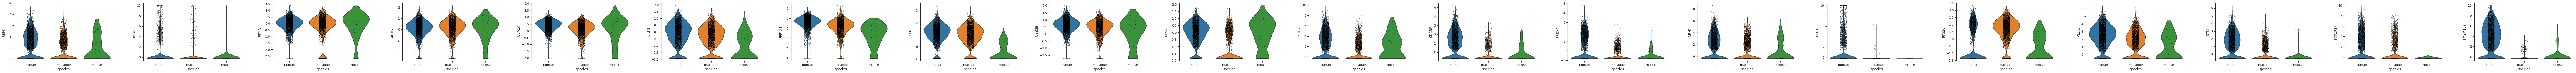

In [120]:
c='11_name'
genes=de_dfs[0][c][-20:]
print(c.replace('_name',''))
sc.pl.violin(adata[adata.obs['scgpgmm_cluster']==c.replace('_name',''),:],
         groupby='species',keys=genes,use_raw=False)


In [ ]:
de=pyro.param('species_de').detach().cpu().numpy()
de_dfs=[]
for s in range(de.shape[0]):
    species_de=[]
    species_de_label=[]
    marker_coefs=[]
    marker_coefs_name=[]
    for t in range(de.shape[1]):
        species_de.append(adata.var.index[de[s,t,:].argsort()])
        species_de.append(de[s,t,de[s,t,:].argsort()])
        species_de_label.append(str(t)+'_'+'name')
        species_de_label.append(str(t)+'_'+'coef')
    pd.DataFrame(species_de,index=species_de_label).T.to_csv(os.path.join('/home/mtschmitz/coefs','DE_coefs_'+adata.obs.species.cat.categories[s]+'.csv'))
    de_dfs.append(pd.DataFrame(species_de,index=species_de_label).T)

In [ ]:
seaborn.scatterplot(coefs.flatten(),de[0].flatten(),alpha=0.01)

In [ ]:
seaborn.scatterplot(pyro.param('s_inverse_dispersion').detach().cpu().expand(de[0].shape).numpy().flatten(),de[0].flatten(),alpha=0.01)

In [ ]:
dc=pyro.param('species_dc').detach().cpu().numpy()
for s in range(dc.shape[0]):
    species_dc=[]
    species_dc_label=[]
    marker_coefs=[]
    marker_coefs_name=[]
    for t in range(dc.shape[1]):
        species_dc.append(adata.var.index[dc[s,t,:].argsort()])
        species_dc.append(dc[s,t,dc[s,t,:].argsort()])
        species_dc_label.append(str(t)+'_'+'name')
        species_dc_label.append(str(t)+'_'+'coef')
    pd.DataFrame(species_dc,index=species_dc_label).T.to_csv(os.path.join('/home/mtschmitz/coefs','DC_coefs_'+adata.obs.species.cat.categories[s]+'.csv'))


In [ ]:
dc=pyro.param('species_dm').detach().cpu().numpy()
for s in range(dc.shape[2]):
    species_dc=[]
    species_dc_label=[]
    marker_coefs=[]
    marker_coefs_name=[]
    for t in range(dc.shape[0]):
        module_names=np.array(range(dc.shape[1]))[dc[t,:,s].argsort()]
        species_dc.append(['module_'+str(i) for i in module_names])
        species_dc.append(dc[t,dc[t,:,s].argsort(),s])
        species_dc_label.append(str(t)+'_'+'name')
        species_dc_label.append(str(t)+'_'+'coef')
    pd.DataFrame(species_dc,index=species_dc_label).T.to_csv(os.path.join('/home/mtschmitz/coefs','DM_coefs_'+adata.obs.species.cat.categories[s]+'.csv'))

In [ ]:
marker_coefs=[]
marker_coefs_name=[]
for t in range(de.shape[1]):
    marker_coefs.append(adata.var.index[coefs[t,:].argsort()])
    marker_coefs.append(coefs[t,coefs[t,:].argsort()])
    marker_coefs_name.append(str(t)+'_'+'name')
    marker_coefs_name.append(str(t)+'_'+'coef')
marker_coefs=pd.DataFrame(marker_coefs,index=marker_coefs_name).T
marker_coefs.to_csv(os.path.join('/home/mtschmitz/coefs','marker_coefs.csv'))

In [ ]:
mod_coefs=pyro.param('z_decoder_weight').detach().cpu().numpy()
marker_coefs=[]
marker_coefs_name=[]
for t in range(mod_coefs.shape[0]):
    marker_coefs.append(adata.var.index[mod_coefs[t,:].argsort()])
    marker_coefs.append(mod_coefs[t,mod_coefs[t,:].argsort()])
    marker_coefs_name.append(str(t)+'_'+'name')
    marker_coefs_name.append(str(t)+'_'+'coef')
mod_coef_table=pd.DataFrame(marker_coefs,index=marker_coefs_name).T
mod_coef_table.to_csv(os.path.join('/home/mtschmitz/coefs','module_coefs.csv'))

In [ ]:
locs=pyro.param('locs').detach().cpu().numpy()
pd.DataFrame(locs,index=['cluster_'+str(i) for i in range(locs.shape[0])],columns=['module_'+str(i) for i in  range(locs.shape[1])])

In [ ]:
marker_coefs=[]
marker_coefs_name=[]
for t in range(locs.shape[0]):
    mod_names=np.array(range(locs.shape[1]))[locs[t,:].argsort()]
    marker_coefs.append(['module_'+str(i) for i in mod_names])
    marker_coefs.append(locs[t,locs[t,:].argsort()])
    marker_coefs_name.append(str(t)+'_'+'name')
    marker_coefs_name.append(str(t)+'_'+'coef')
pd.DataFrame(marker_coefs,index=marker_coefs_name).T.to_csv(os.path.join('/home/mtschmitz/coefs','anc_loc_coefs.csv'))

In [ ]:
pd.DataFrame(marker_coefs,index=marker_coefs_name).T

In [ ]:
import gseapy as gp
import re

gp.get_library_name() 

In [84]:
weight_tab=pd.DataFrame(cpu_dict['z_decoder_weight'].numpy().T,index=adata.var.index)

In [85]:
overall = gp.prerank(rnk=weight_tab, gene_sets='GO_Biological_Process_2023',#gene_sets=['KEGG_2019_Human','GWAS_Catalog_2023'],
                     threads=8,
                     permutation_num=500,no_plot=True, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png', seed=6,verbose=True)

2023-07-09 20:38:47,914 [WARNING] Duplicated values found in preranked stats:
sample	ratio
0     0.00%
1     0.00%
2     0.01%
3     0.01%
4     0.00%
5     0.00%
6     0.00%
7     0.00%
8     0.00%
9     0.01%
10    0.01%
11    0.01%
12    0.02%
13    0.01%
14    0.01%
15    0.00%
16    0.00%
17    0.01%
18    0.01%
19    0.00%
20    0.00%
21    0.00%
22    0.00%
23    0.01%
24    0.00%
25    0.00%
26    0.01%
27    0.00%
28    0.00%
29    0.00%
30    0.00%
31    0.00%
32    0.01%
33    0.01%
34    0.01%
35    0.01%
36    0.00%
37    0.01%
38    0.01%
39    0.01%
40    0.00%
41    0.01%
42    0.00%
43    0.01%
44    0.00%
45    0.01%
46    0.01%
47    0.00%
48    0.01%
49    0.02%
50    0.00%
51    0.00%
52    0.00%
53    0.00%
54    0.00%
55    0.01%
56    0.01%
57    0.00%
58    0.01%
59    0.00%
60    0.00%
61    0.01%
62    0.01%
63    0.01%
64    0.01%
65    0.01%
66    0.00%
67    0.01%
68    0.02%
69    0.01%
70    0.01%
71    0.00%
72    0.00%
73    0.01%
74    0.01%
75    0.0

In [ ]:
pre_res={}
for x in tqdm.tqdm(weight_tab.columns):
    pre_res[x] = gp.prerank(rnk=weight_tab[x], gene_sets='GO_Biological_Process_2023',#gene_sets=['KEGG_2019_Human','GWAS_Catalog_2023'],
                         threads=1,
                         permutation_num=1000,no_plot=True, # reduce number to speed up testing
                         outdir='test/prerank_report_kegg', format='png', seed=666)

In [ ]:
dfs=[]
pval_name='FDR q-val'
for x in pre_res.keys():
    enrichDF=pre_res[x].res2d.loc[:,[pval_name,'Term']]
    enrichDF['celltype']=x
    enrichDF.index=enrichDF['Term']
    enrichDF=enrichDF.loc[enrichDF[pval_name]<.03,:]
    enrichDF=enrichDF.loc[~np.isnan(enrichDF[pval_name].values.astype(float)),:]
    enrichDF=enrichDF.iloc[0:min(enrichDF.shape[0],2),:]
    dfs.append(enrichDF)
catMat=pd.concat(dfs,axis=1, join='outer')
fdrMat=catMat.loc[:,catMat.columns.str.contains(pval_name)]
fdrMat.columns=list(pre_res.keys())
#print(fdrMat)
seaborn.set(style="white")
seaborn.set(font_scale=3)
plt.figure(figsize = (30,20))
seaborn.heatmap(-np.log10(fdrMat+.001),cmap='RdYlBu_r',yticklabels=True, linecolor='white',square=True,)
plt.show()